# Intro to Autoencoders

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

In [2]:
RUNNING_IN_COLAB = True

if RUNNING_IN_COLAB:
    # Uses a private Auth Token, giving read and write access to repo
    # TO DELETE IF REPO GOES PUBLIC
    REPO_URL = 'https://github.com/Pumafi/geostats_deep_learning.git'
    BRANCH   = 'main'
    REPO_DIR = 'geostats_deep_learning'

    from pathlib import Path

    %cd /content

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}
    
    %cd {REPO_DIR}

/content
Cloning into 'geostats_deep_learning'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (29/29), 29.71 MiB | 8.74 MiB/s, done.
/content/geostats_deep_learning


## Import TensorFlow and other libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

## First example: Basic autoencoder

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

It should be a simple model, with only one Dense layer in the encoder, and one Dense layer in the decoder. Use a `relu` activation in encoder and a `sigmoid` activation in decoder.


### Loading MNIST data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [6]:
latent_dim = 2

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),
      layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
      layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU()),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
      layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

***What loss function should you use ?***

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build([None, x_train.shape[1], x_train.shape[2], 1])
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 108,866
Trainable params: 108,866
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)          

In [8]:
autoencoder.compile(optimizer=keras.optimizers.experimental.Adam(learning_rate=5e-4), loss=losses.MeanSquaredError())
autoencoder.build([None, x_train.shape[1], x_train.shape[2], 1])
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 108,866
Trainable params: 108,866
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)          

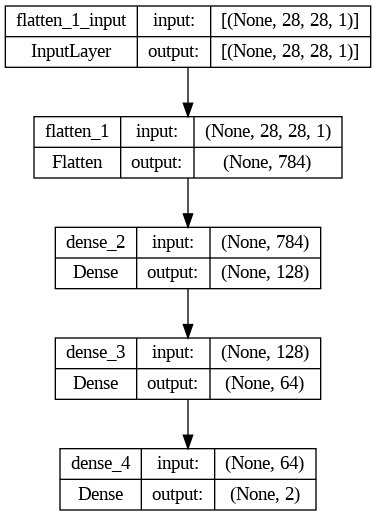

In [9]:
keras.utils.plot_model(autoencoder.encoder, "autoencoder_encoder.png", show_shapes=True)

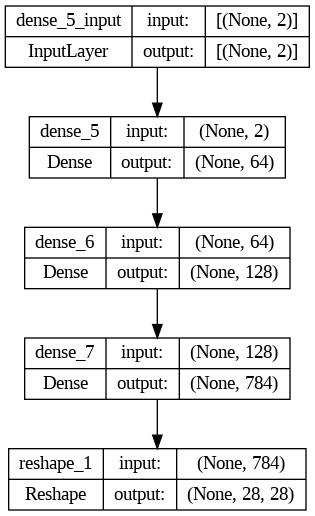

In [10]:
keras.utils.plot_model(autoencoder.decoder, "autoencoder_decoder.png", show_shapes=True)

##### Train the model.

The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.

***What is the input and what is the target in this model ?***

***What do you use as validation data ?***

Use the [fit method](https://keras.io/api/models/model_training_apis/), and enable shuffling.

In [11]:

epochs=20

autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 15s 7ms/step - loss: 0.0589 - val_loss: 0.0522
Epoch 2/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0505 - val_loss: 0.0482
Epoch 3/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0472 - val_loss: 0.0460
Epoch 4/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0455 - val_loss: 0.0448
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0444 - val_loss: 0.0439
Epoch 6/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0435 - val_loss: 0.0430
Epoch 7/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0428 - val_loss: 0.0425
Epoch 8/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0422 - val_loss: 0.0422
Epoch 9/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0417 - val_loss: 0.0414
Epoch 10/20
1875/1875 [==============================] - 15s 8ms/step - l

In [12]:
# %load Corrections/encoder_corr_3.py

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [13]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

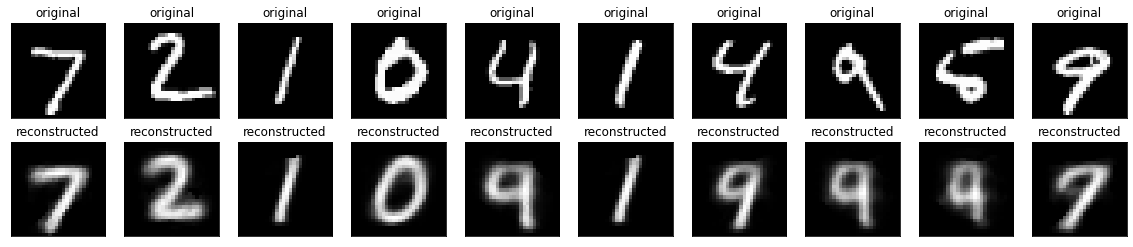

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.squeeze(x_test[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(np.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

#### Visualising the latent space through PCA

In [15]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# This code is for visualisation of data
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(15, 5))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'Colormap Legend', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        for i in range(10):
            ax.text(0.03+i*0.1, 0.5, i, va='center', ha='right', fontsize=10, transform=ax.transAxes)
    

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list


In [16]:
x_train.shape

(60000, 28, 28)

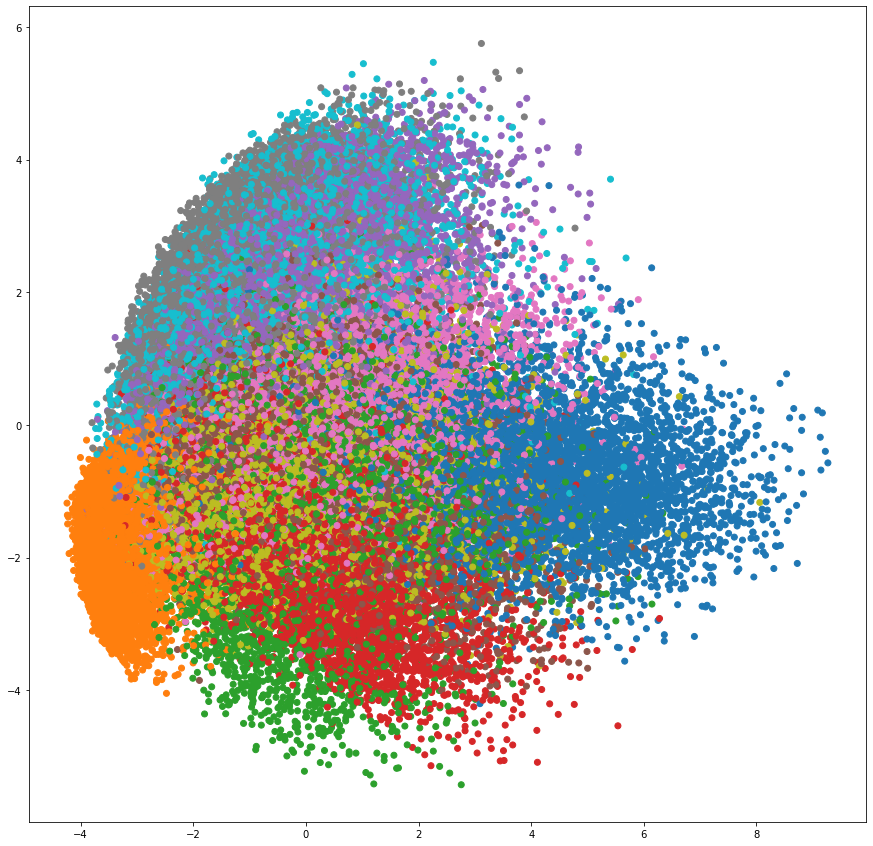

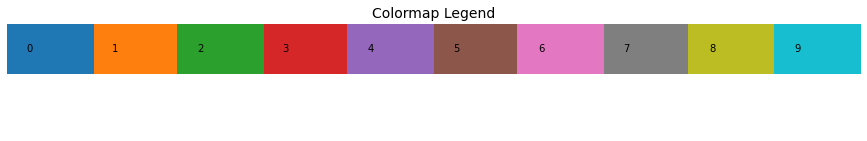

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

reduced_data_pca = PCA(n_components=2).fit_transform(np.reshape(x_train, [-1, 28*28]))
fig = plt.figure(figsize=(15, 15))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=y_train, cmap="tab10")

plot_color_gradients('Qualitative', ['tab10'])



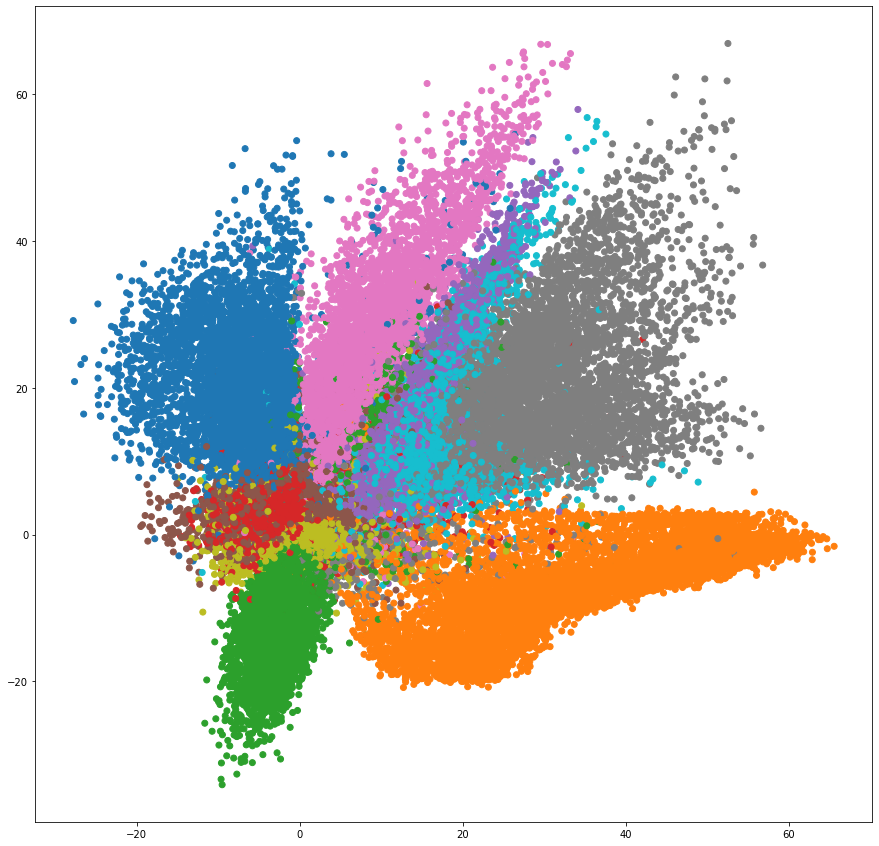

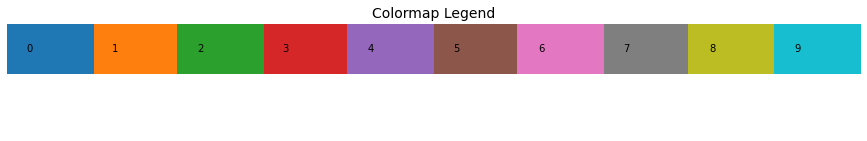

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_encoded= autoencoder.encoder(x_train)
fig = plt.figure(figsize=(15, 15))
plt.scatter(data_encoded[:, 0], data_encoded[:, 1], c=y_train, cmap="tab10")
plot_color_gradients('Qualitative', ['tab10'])



## Second example: Image denoising


An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's import a new dataset.

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [19]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [20]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [21]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

Add random noise to the Training and Validation data using the following formula:

X + noise_factor * $N(0, 1)$

The noise factor determines the strengh of the noise.

In [22]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


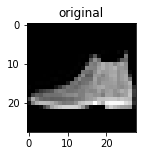

In [23]:
n = 1
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

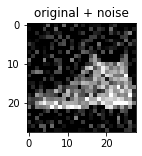

In [24]:
n = 1
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

Before coding, think about your architecture. Do you need padding ? How do you Upsample from the latent space and Downsample the image (maybe the `strides` parameter of Convolutions can help)?

Use a ReLU activation in the hidden layers, but a sigmoid as output activation.

The whole model should be Fully Convolutional (no Flatten or Dense). Use (3x3) Convolution Kernels.


In [25]:

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [26]:
# %load Corrections/encoder_corr_4.py

In [27]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [28]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/5
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0192 - val_loss: 0.0114
Epoch 2/5
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 3/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/5
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 5/5
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0087 - val_loss: 0.0086


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [29]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [30]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [31]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

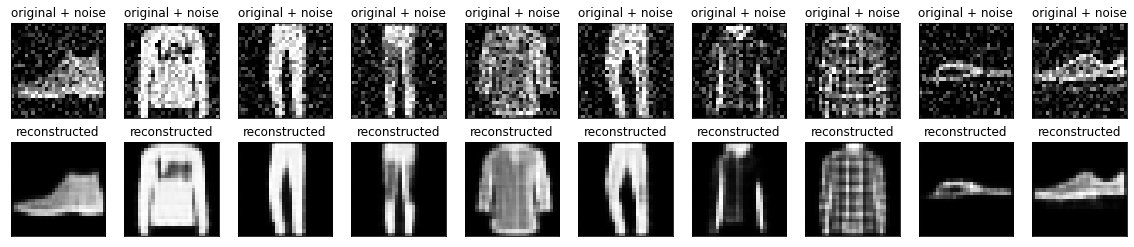

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [33]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [34]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [35]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [36]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

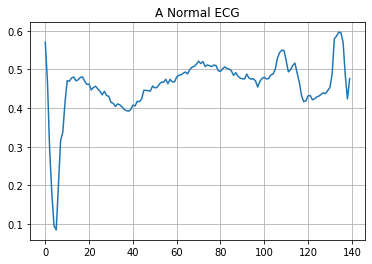

In [37]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

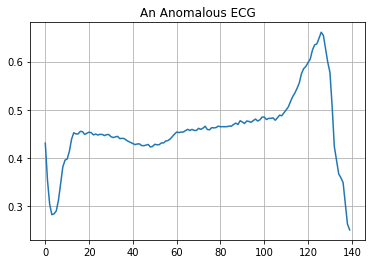

In [38]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [39]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [40]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [41]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 47ms/step - loss: 0.0584 - val_loss: 0.0537
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0569 - val_loss: 0.0528
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0558 - val_loss: 0.0517
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0543 - val_loss: 0.0504
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0523 - val_loss: 0.0489
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0459 - val_loss: 0.0457
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0449
Epoch 9/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0385 - val_loss: 0.0432
Epoch 10/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0355 - val_loss: 0.0411
Epoch 11/20
5/5 [============

Plot the loss and the validation loss using the history dictionary returned by the `fit` function.

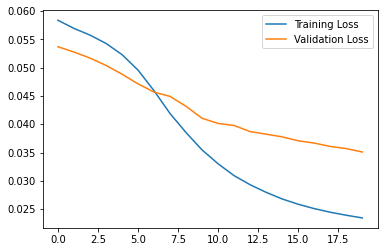

In [42]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

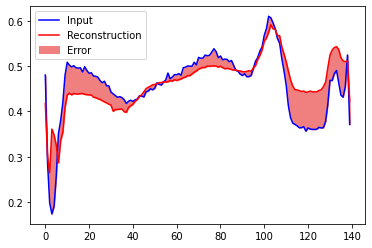

In [43]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

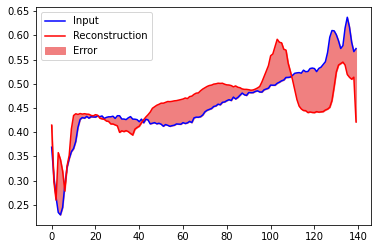

In [44]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 2ms/step


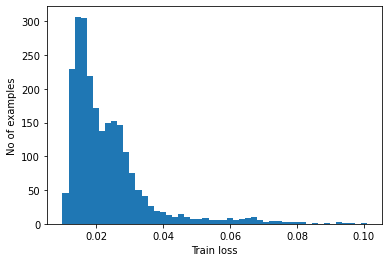

In [45]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [46]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03519978


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

14/14 [==============================] - 0s 2ms/step


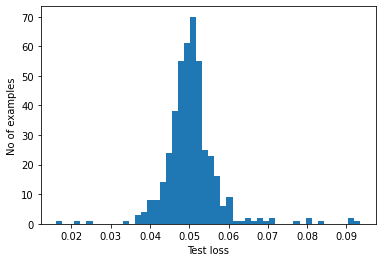

In [47]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [48]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [49]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
